In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline

Load a mean pulse profile for B1957+20

Mean pulse flux = 0.0370254054243 Jy


(-0.1, 0.6)

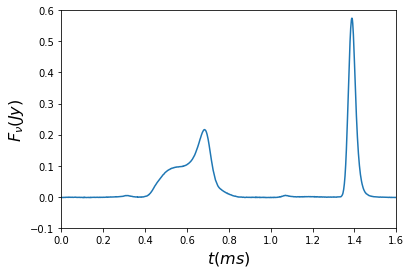

In [6]:
mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
mean_value = (np.mean(mean_profile) / np.median(mean_profile) - 1) * 12.

print("Mean pulse flux = %s Jy" % (mean_value))

plt.plot(np.arange(1000)/1000.*1.6, meanprof_Jy)
plt.xlabel('$t (ms)$', fontsize=16)
plt.ylabel(r'$F_{\nu} (Jy)$', fontsize=16)
plt.xlim(0,1.6)
plt.ylim(-.1, 0.6)

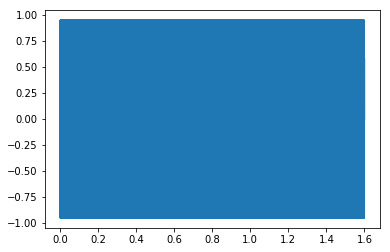

In [45]:
angular_freq = 2*np.pi*311.25*u.MHz
t = np.linspace(0, 1.6, 5001)*u.ms
phase = np.sin(angular_freq*t*u.rad)

plt.plot(t, phase)

In [47]:
E_field = np.sqrt(meanprof_Jy)*phase

plt.plot(t, E_field)

/opt/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


ValueError: operands could not be broadcast together with shapes (5001,) (1000,) 